# Seizure detection sandbox

## Workspace Preparation

In [17]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
from tqdm import tqdm
from kneed import KneeLocator

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import seaborn as sns
from sklearn.linear_model import LinearRegression


# Imports for deep learning
import random
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# OS imports
from os.path import join as ospj
from utils import *
import sys
from seizure_detection_pipeline_pre_train import *
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

sys.path.append('/users/wojemann/DSOSD/')
from DSOSD.model import NDD

In [18]:
_,_,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))

In [19]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['lines.linewidth'] = 2

plt.rcParams['xtick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['ytick.major.size'] = 5  # Change to your desired major tick size
plt.rcParams['xtick.minor.size'] = 3   # Change to your desired minor tick size
plt.rcParams['ytick.minor.size'] = 3   # Change to your desired minor tick size

plt.rcParams['xtick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['ytick.major.width'] = 2  # Change to your desired major tick width
plt.rcParams['xtick.minor.width'] = 1  # Change to your desired minor tick width
plt.rcParams['ytick.minor.width'] = 1  # Change to your desired minor tick width

In [20]:
set_seed(5210)

In [21]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information_BIDS.csv"))
pt = 'HUP238'
montage = 'bipolar'

## Data Loading

In [22]:
# Loading data from bids
inter,fs_raw = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
# plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [23]:
# Pruning channels
chn_labels = remove_scalp_electrodes(inter.columns)
inter_raw = inter[chn_labels]
# plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [24]:
inter_raw.columns

Index(['Fp02', 'LA01', 'LA02', 'LA03', 'LA04', 'LA05', 'LA06', 'LA07', 'LA08',
       'LA09',
       ...
       'LY02', 'LY03', 'LY04', 'LY05', 'LY06', 'LY07', 'LY08', 'LY10', 'LY11',
       'LY12'],
      dtype='object', length=131)

In [25]:
electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
if pt[:3] == 'CHO':
    suffix = ['CHOPR','CHOPM']
else:
    suffix = ['dkt','atropos']
electrode_localizations.name = clean_labels(electrode_localizations.name,pt) #don't end up using grey/white matter
electrode_regions.name = clean_labels(electrode_regions.name,pt)
electrode_localizations.to_pickle(ospj(prodatapath,pt,f'electrode_localizations_{suffix[1]}.pkl')) #don't end up using grey/white matter
electrode_regions.to_pickle(ospj(prodatapath,pt,f'electrode_localizations_{suffix[0]}.pkl'))
neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter_raw.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
inter_neural = inter_raw[neural_channels]

In [26]:
# inter_neural.iloc[:,:22] = inter_neural.iloc[:,:22]*1e-3

In [27]:
inter_prep,fs,mask = preprocess_for_detection(inter_neural,fs_raw,wavenet=False,target=128)

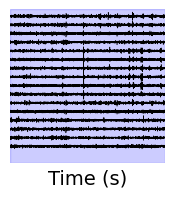

In [29]:
if pt == 'HUP238':
    elements = ['LC01-LC02', 'LC03-LC04', 'LC02-LC03', 'LI01-LI02', 'LB02-LB03',
        'LB01-LB02', 'LB03-LB04', 'LA01-LA02', 'LU01-LU02', 'LA03-LA04',
        'LA04-LA05', 'LI02-LI03', 'LA02-LA03', 'LT01-LT02', 'LI03-LI04',
        'LI06-LI07', 'LI07-LI08', 'LI05-LI06', 'LI04-LI05', 'LI08-LI09']
    elements_clean = [e for e in elements if e in inter_prep.columns]
    elements_sorted = np.sort(elements_clean)
    plot_iEEG_data(inter_prep.loc[:,elements_sorted],fs,minmax=True,fig_size=(2,2),empty=True)
else:
    plot_iEEG_data(inter_prep,fs,minmax=True,fig_size=(4,4),empty=True)

plt.yticks([])
plt.xticks([])
plt.axvspan(0,len(inter_prep)/fs,color='blue',alpha=0.2)
plt.xlabel('Time (s)')
plt.savefig(ospj(figpath,'interictal_baseline_example.pdf'),bbox_inches='tight')

In [30]:
# plot_iEEG_data(model.inter,np.arange(len(model.inter))/fs)

In [31]:
seizure_times = seizures_df[seizures_df.Patient == pt]
qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
for i,(_,sz_row) in enumerate(qbar):
    set_seed(1071999)
    if i <=2:
        continue
    # Load in seizure and metadata for BIDS path
    seizure_raw,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
    print(task)
    break

ictal294225


In [32]:
# Filter out bad channels from interictal clip
seizure_neural = seizure_raw[neural_channels]
# seizure_neural.loc[:,:22] = seizure_neural.iloc[:,:22]*1e-3
# plot_iEEG_data(seizure_neural,np.arange(len(seizure_neural))/fs_raw)

In [33]:
seizure_prep,fs = preprocess_for_detection(seizure_neural,fs_raw,
                                                wavenet=False,
                                                pre_mask=mask,
                                                target=128)

In [34]:
seizure_prep.max()
noisy_channel_mask = seizure_prep.abs().max() <= (np.median(seizure_prep.abs().max())*50)
seizure_prep.columns[~noisy_channel_mask]
seizure_slice = seizure_prep.loc[120*fs:len(seizure_prep)-(120*fs),:]
seizure_prep = seizure_prep.loc[:,noisy_channel_mask]

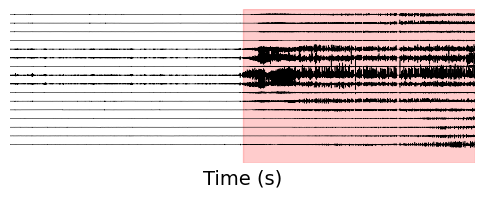

In [36]:
if pt == 'HUP238':   
    plot_iEEG_data(seizure_prep.loc[60*fs:180*fs,elements_sorted],fs,t_offset=-60,minmax=False,fig_size=(6,2),empty=True)
else:
    plot_iEEG_data(seizure_prep.loc[60*fs:180*fs,:],fs,t_offset=-60,minmax=False,fig_size=(6,4),empty=True)
plt.yticks([])
plt.xticks([])
plt.axvspan(0,len(inter_prep)/fs,color='red',alpha=0.2)
plt.xlabel('Time (s)')
plt.savefig(ospj(figpath,'ictal_seizure_example.pdf'),bbox_inches='tight')

## Plotting

In [37]:
model= LTI(1,.5,128)
model.fit(inter_prep.loc[:,noisy_channel_mask])

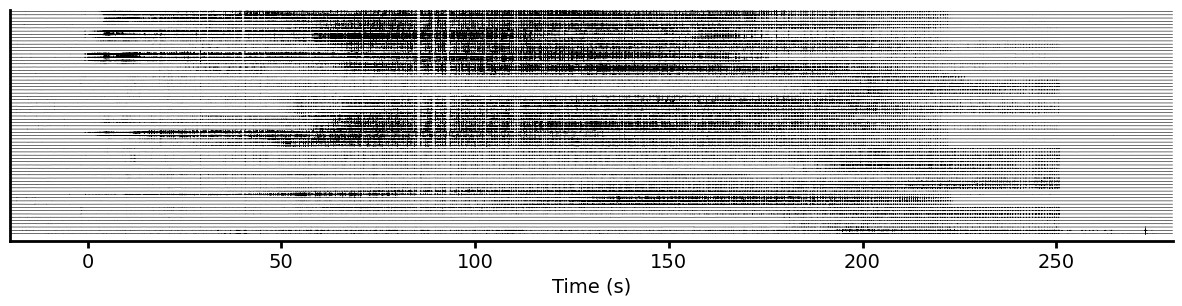

In [39]:
plot_data = pd.DataFrame(model.scaler.transform(seizure_prep),columns=seizure_prep.columns)
plot_time = np.arange(len(seizure_prep))/fs
plot_inds = (plot_time > 100) & (plot_time < 400)
plot_iEEG_data(plot_data.loc[plot_inds,:],fs,fig_size=(15,3),t_offset=-20)
plt.yticks([])
plt.savefig(ospj(figpath,'full_seizure_example.pdf'),bbox_inches='tight')

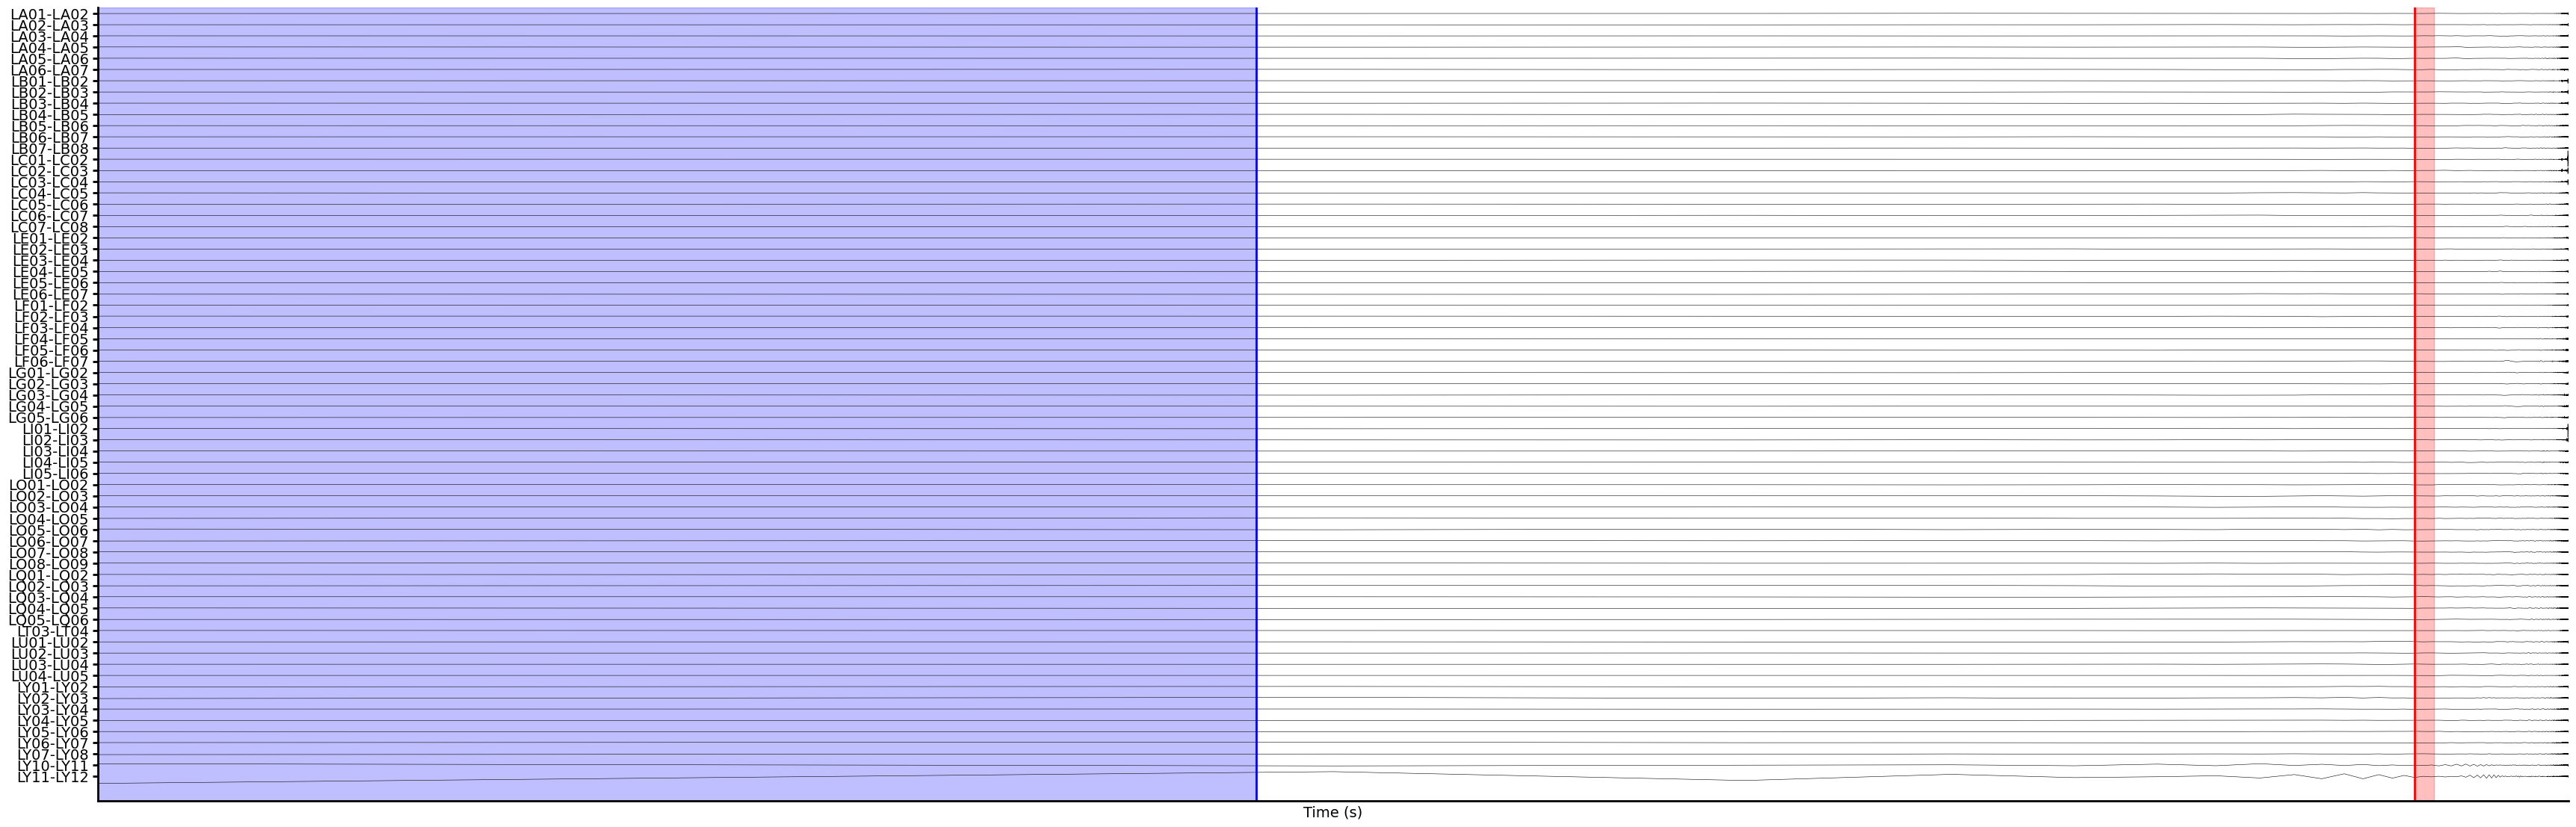

In [40]:
plot_data = pd.DataFrame(model.scaler.transform(seizure_prep),columns=seizure_prep.columns)
plot_time = np.arange(len(seizure_prep))/fs
plot_inds = (plot_time > 0) & (plot_time < 150)
plot_iEEG_data(plot_data.loc[plot_inds,noisy_channel_mask],plot_time[plot_inds])
plt.axvline(0,color='blue')
plt.axvline(60,color='blue')
plt.axvspan(0,60,color='blue',alpha=0.25)
plt.axvline(120,color='red')
# plt.axvline(130,color='red')
plt.axvspan(120,121,color='red',alpha=0.25)
# plt.axvspan(130,131,color='red',alpha=0.25)
plt.xticks([])
plt.savefig(ospj(figpath,'example_seizure_onset.pdf'))

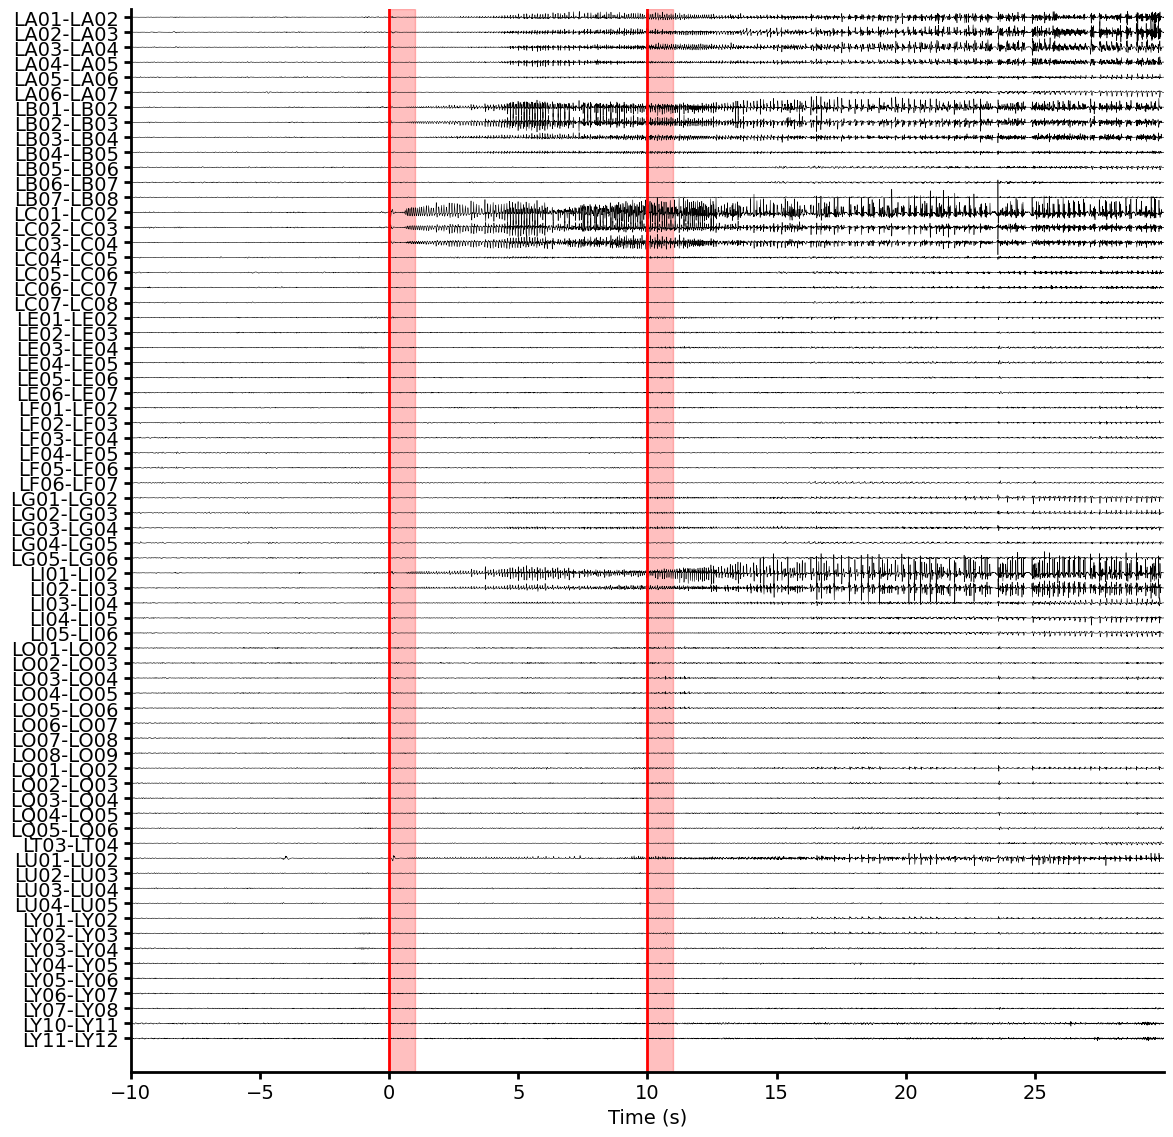

In [41]:
plot_time = np.arange(len(seizure_prep))/fs
plot_inds = (plot_time > 110) & (plot_time < 160)
plot_iEEG_data(plot_data.loc[plot_inds,noisy_channel_mask],plot_time[plot_inds],t_offset=-10)
plt.axvline(0,color='red')
plt.axvline(10,color='red')
plt.axvspan(0,1,color='red',alpha=0.25)
plt.axvspan(10,11,color='red',alpha=0.25)
# plt.xticks([])
plt.savefig(ospj(figpath,'example_seizure_just_onset.pdf'))

## Linear Modeling

In [53]:
model.fit(seizure_prep.loc[:fs*60,:])

In [54]:
preds = model(seizure_prep)
preds_reject = preds[noisy_channel_mask,:]
preds_smooth = sc.ndimage.uniform_filter1d(preds_reject,20,axis=1)

([], [])

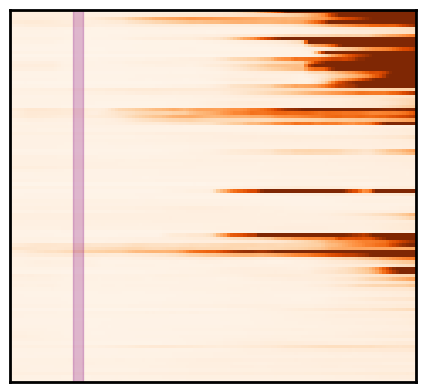

In [55]:
times = model.get_times(seizure_prep)
time_mask = (times > 110) & (times < 170)
plt.matshow(preds_smooth[:,time_mask],cmap='Oranges')
plt.clim([0,10])
tiks = np.arange(0,preds_smooth.shape[1],50)
# plt.xticks(tiks,times[tiks].astype(int))
span_start = np.argmin(np.abs(times-10))
plt.axvspan(span_start,span_start+3,alpha=0.25,color='Purple')
plt.xticks([])
plt.yticks([])

([], [])

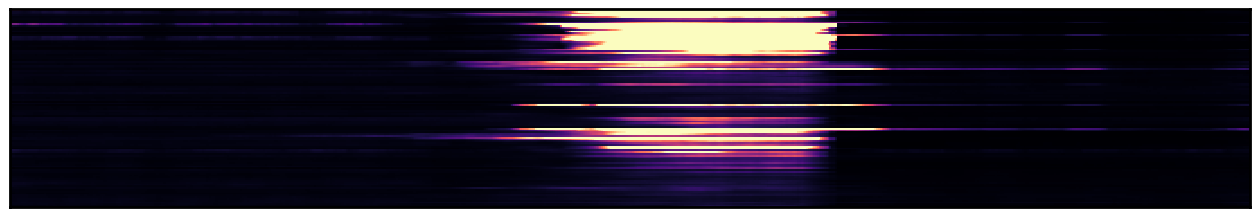

In [56]:
plt.matshow(preds_smooth,interpolation='none')
plt.clim([0,10])
plt.xticks([])
plt.yticks([])

In [57]:
ch_mask_early = np.zeros_like(preds_smooth)
ch_mask_late = np.zeros_like(preds_smooth)
ch_mask_all = np.zeros_like(preds_smooth)
early = np.sum(preds_smooth[:,:118] > .2,axis=1) > 30
late = np.sum(preds_smooth[:,-118:] > .2,axis=1) > 30
all_mask = np.sum(preds_smooth > 0.75,axis=1) > preds_smooth.shape[1]/2
ch_mask_early[early,:] = 1
ch_mask_late[late,:] = 1
ch_mask_all[all_mask,:] = 1
# plt.imshow(ch_mask_early)
# plt.figure()
# plt.imshow(ch_mask_late)
# plt.figure()
# plt.imshow(ch_mask_early + ch_mask_late)
# plt.figure()
# plt.imshow(ch_mask_all)

In [58]:
# print(seizure_prep.columns[noisy_channel_mask][early])
# print(seizure_prep.columns[noisy_channel_mask][late])

In [59]:
# time_mask = (times > 120) & (times < (max(times)-120))
# preds_smooth_reject = preds_smooth[~late,:]
# plt.imshow(preds_smooth_reject[:,time_mask])
# plt.clim(0,100)
# plt.yticks([])
# plt.xticks([])

In [60]:
# onset_chs_list = []
# for t in np.arange(0,1,.01):
#     late = np.sum(preds_smooth[:,-118:] > t,axis=1) > 30
#     preds_smooth_reject = preds_smooth[~late,:]
#     onset_ch_idxs = np.all(preds_smooth_reject[:,118:123]>t,axis=1)
#     sz_chs = seizure_prep.columns[~late]
#     onset_chs = sz_chs[onset_ch_idxs]
#     onset_chs_list.append(onset_chs)

### Unsupervised classification

#### Knee

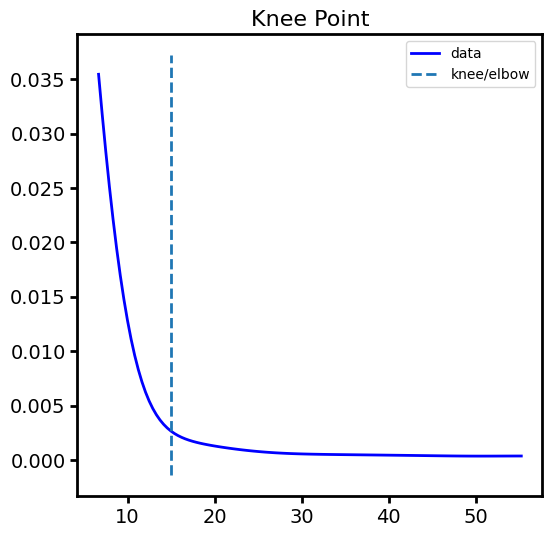

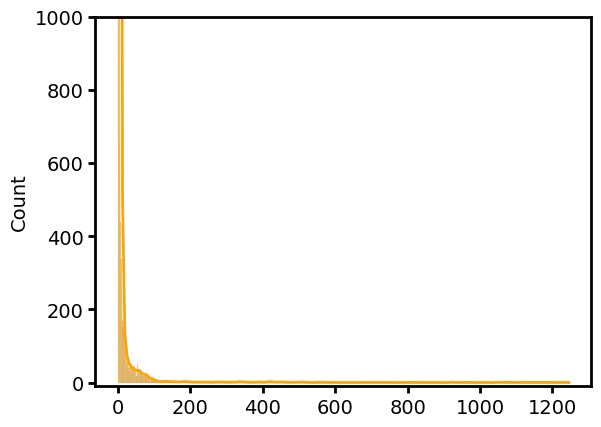

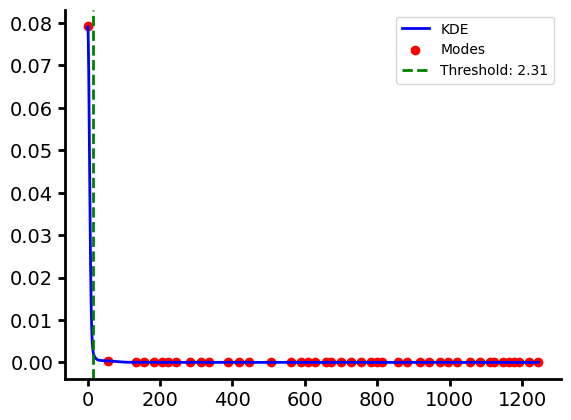

In [61]:
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
ch_reject = np.zeros((preds_smooth.shape[0],1),dtype=bool)
ch_thresholds = np.zeros((preds_smooth.shape[0],1))
# for ch in range(preds_smooth.shape[0]):
    # Example: Seizing probabilities
# probabilities = preds_smooth[:,240:-240].flatten()
probabilities = preds_smooth.flatten()
probabilities = probabilities[probabilities < np.percentile(probabilities,99.99)]
# KDE using scipy's gaussian_kde
kde = gaussian_kde(probabilities,'scott')

# Define an x-axis range to evaluate the KDE
x_vals = np.linspace(min(probabilities), max(probabilities), 3000)
kde_vals = kde(x_vals)

# Find peaks (modes) in the KDE
peaks, _ = find_peaks(kde_vals)

# Find troughs (local minima) between peaks
try:
    biggest_pk_idx = np.where(kde_vals[peaks]>(np.mean(kde_vals)+np.std(kde_vals)))[0][-1]
except:
    biggest_pk_idx = np.argmax(kde_vals[peaks])
# biggest_pk_idx = np.argmax(kde_vals[peaks])
start, end = peaks[biggest_pk_idx], peaks[biggest_pk_idx+1]
trough_idx = np.argmin(kde_vals[start:end]) + start
# trough_idx = int((end-start)/2 + start)
# trough_idx = np.argmin(fit_mdl(x_vals))
# threshold = x_vals[int(trough_idx)]

kneedle = KneeLocator(x_vals[start+15:end],kde_vals[start+15:end],
                      curve='convex',direction='decreasing',interp_method='polynomial')
kneedle.plot_knee()
threshold = kneedle.knee
# print(f"{seizure_prep.columns[ch]} Threshold between modes: {threshold}")
plt.figure()
# # Plot the results
sns.histplot(probabilities,color='orange',bins=1000,kde=True)
plt.ylim([-10,1000])
plt.figure()
plt.plot(x_vals, kde_vals, label="KDE",color='blue')
plt.scatter(x_vals[peaks], kde_vals[peaks], color='red', label="Modes")
# plt.scatter(x_vals[trough_idx], kde_vals[trough_idx], color='green', label="Knee (Threshold)")
# plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold: {threshold:.3f}')
plt.axvline(threshold, color='green', linestyle='--', label=f'Threshold: 2.31')
sns.despine()
plt.legend()
plt.show()

In [62]:
print(np.mean(kde_vals),np.var(kde_vals))

0.0004733591364897698 2.5034574677330548e-05


([], [])

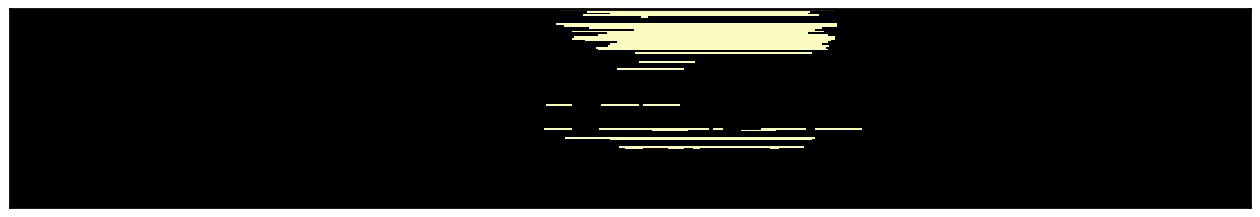

In [63]:
plt.matshow(preds_smooth[:,:]>threshold,interpolation='none')
plt.yticks([])
plt.xticks([])

### Gamma

In [64]:
from scipy.stats import gamma

# Step 1: Fit Gamma distribution to interictal data
def fit_gamma(interictal_data):
    shape, _, scale = gamma.fit(interictal_data, floc=0)  # force location to 0
    return shape, scale

# Step 2: Calculate the confidence value for a given loss
def confidence_outside_distribution(loss_value, shape, scale):
    # Calculate the CDF for the given loss value
    cdf_value = gamma.cdf(loss_value, a=shape, scale=scale)
    
    # Confidence value that the loss is outside the interictal distribution
    confidence_outside = cdf_value
    return confidence_outside

def get_95_confidence_threshold(shape, scale):
    # Get the loss value at the 95th percentile using the PPF (percent point function)
    threshold_value = gamma.ppf(0.95, a=shape, scale=scale)
    return threshold_value
 
# Example usage
loss_value = preds_smooth[:,:-240] # Example new loss value

# Fit Gamma distribution to interictal data
shape, scale = fit_gamma(loss_value)

# Calculate the confidence for the given loss value
confidence = confidence_outside_distribution(preds_smooth, shape, scale)

# print(f"Confidence that the loss value {loss_value} is outside the interictal distribution: {confidence:.4f}")

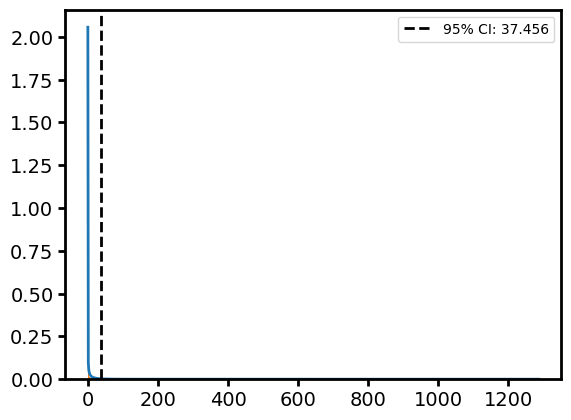

In [65]:
x_plot = np.linspace(np.min(preds_smooth),np.max(preds_smooth),1000)
plotting_pdf = sc.stats.gamma.pdf(x_plot,a=shape,scale=scale)
plt.plot(x_plot,plotting_pdf);
plt.hist(preds_smooth.flatten(),density=True,bins=1000);
thresh = sc.stats.gamma.ppf(0.95,a=shape,scale=scale)
plt.axvline(thresh,color='k',linestyle='--',label=f'95% CI: {np.round(thresh,3)}');
plt.legend()
# plt.figure()
# plt.plot(loss_value.T)

([], [])

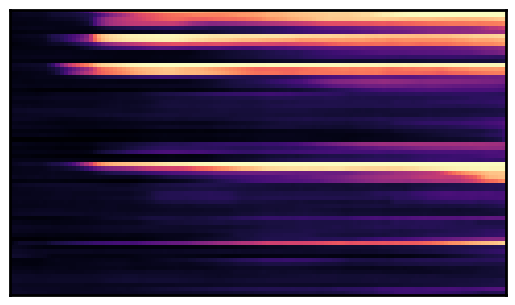

In [63]:
plt.imshow(confidence.reshape(preds_smooth.shape)[:,time_mask])
plt.yticks([])
plt.xticks([])

([], [])

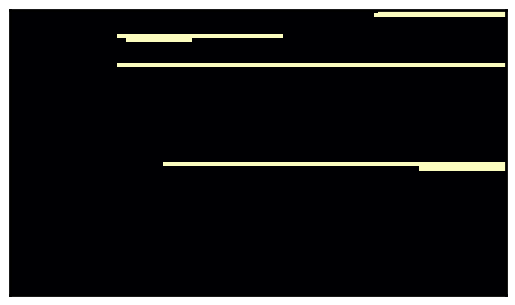

In [64]:
plt.imshow(confidence.reshape(preds_smooth.shape)[:,time_mask]>0.95)
plt.yticks([])
plt.xticks([])

In [65]:
threshold_value = gamma.ppf(0.95, a=shape, scale=scale)
threshold_value

156.1073453441415

### Measuring dynamic spread

In [66]:
# First seizing index at the final threshold after offset
# UEO channels at first seizing index + 3 indices
# Seizing index and time since first seizing index for each channel
seizure_nart = seizure_prep.loc[:,noisy_channel_mask]
time_wins = model.get_times(seizure_nart)
sz_chs = seizure_nart.columns
t = threshold
first_sz_idx_offset = 240
sz_clf_final = preds_smooth > t
# Get channels
sliced_data = sz_clf_final[:,first_sz_idx_offset:]
df = pd.DataFrame(sliced_data).T
seizing = df.rolling(window=3,closed='right').apply(lambda x: (x == 1).all())
first_sz_idxs = seizing.idxmax().to_numpy() - 2
seized_idxs = np.any(sliced_data,axis=1)
first_sz_idxs += first_sz_idx_offset
if sum(seized_idxs) > 0:
    sz_times_arr = time_wins[first_sz_idxs[seized_idxs]]
    sz_times_arr -= np.min(sz_times_arr)
    sz_ch_arr = sz_chs[seized_idxs]
    sz_ch_arr = np.array([s.split("-")[0] for s in sz_ch_arr]).flatten()
else:
    sz_ch_arr = []
    sz_times_arr = []

In [67]:
time_wins[first_sz_idxs[seized_idxs]]

array([123.9921875, 127.9921875, 127.9921875, 154.4921875, 173.4921875,
       176.9921875, 120.9921875, 120.9921875, 148.9921875, 179.9921875,
       182.4921875, 183.9921875, 189.4921875, 120.9921875, 120.9921875,
       120.9921875, 182.4921875, 186.4921875, 185.4921875, 200.4921875,
       228.9921875, 215.4921875, 212.9921875, 198.4921875, 193.9921875,
       192.9921875, 179.9921875, 180.9921875, 180.4921875, 181.4921875,
       180.9921875, 120.9921875, 132.4921875, 163.4921875, 166.4921875,
       167.4921875, 319.4921875, 338.4921875, 320.4921875, 331.4921875,
       189.9921875, 156.4921875, 247.4921875, 244.4921875, 236.9921875,
       313.4921875])

In [68]:
idxs = np.argsort(sz_times_arr)
print(sz_ch_arr[idxs])

['LI01' 'LB01' 'LB02' 'LC03' 'LC02' 'LC01' 'LA01' 'LA02' 'LA03' 'LI02'
 'LB03' 'LA04' 'LU01' 'LI03' 'LI04' 'LI05' 'LA05' 'LA06' 'LB04' 'LG01'
 'LG03' 'LG05' 'LG02' 'LG04' 'LC04' 'LB05' 'LB06' 'LC06' 'LC05' 'LB07'
 'LT03' 'LF06' 'LF05' 'LF04' 'LC07' 'LF03' 'LF02' 'LF01' 'LU04' 'LU03'
 'LU02' 'LY10' 'LO06' 'LQ04' 'LQ05' 'LQ03']


In [97]:
plt.figure(figsize=(4,6))
# plt.bar(np.arange(len(idxs)),sz_times_arr[idxs],color='green')
plot_times_arr = max(sz_times_arr) - sz_times_arr
sns.barplot(x=np.arange(len(idxs)),y=plot_times_arr[idxs],palette='magma_r',orient='v')
sns.despine()
plt.xticks(np.arange(len(idxs)),sz_ch_arr[idxs],rotation=60)
t = plt.yticks()
y_tix = max(sz_times_arr) - np.arange(0,221,20)
plt.yticks(y_tix,np.arange(0,221,20),fontsize=20)
plt.axhline(max(sz_times_arr)-3,ls='--',color='red',linewidth=2)
# plt.axhline(max(sz_times_arr)-10,ls='--',color='blue',linewidth=2)
plt.ylabel("Time (s)",fontsize=24)
plt.title('Seizure spread after onset',fontsize=28)

NameError: name 'sz_times_arr' is not defined

<Figure size 400x600 with 0 Axes>

In [70]:
vals,vecs = sc.linalg.eig(model.model.coef_)

<StemContainer object of 3 artists>

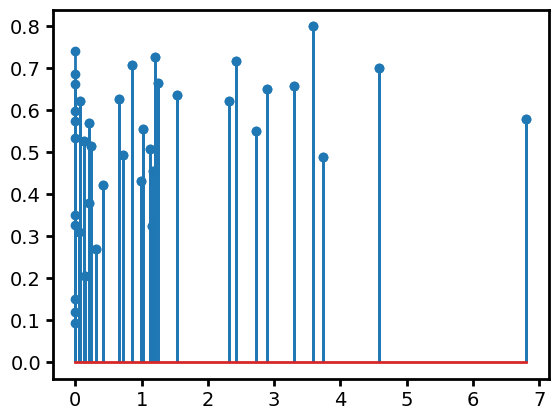

In [71]:
freqs = np.abs(np.imag(vals))*fs/(2*np.pi)
mags = np.abs(np.real(vals))
plt.stem(freqs,mags)

## Deep Learning

In [72]:
 # Instantiate the model
input_size = inter_prep.shape[1]
hidden_size = 10

# Check for cuda
# ccheck = torch.cuda.is_available()
ccheck = False

# Initialize the model
model = LSTMModel(input_size, hidden_size)

# Scale the training data
model.fit_scaler(inter_prep)
inter_z = model.scaler_transform(inter_prep)
inter_z = pd.DataFrame(inter_z,columns=inter_prep.columns)

# Prepare input and target data for the LSTM
input_data,target_data = prepare_segment(inter_z,fs=fs)

dataset = TensorDataset(input_data, target_data)
full_batch = len(dataset)
dataloader = DataLoader(dataset, batch_size=full_batch, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model, this will just modify the model object, no returns
# print("Training patient specific model")
train_model(model,dataloader,criterion,optimizer,ccheck=ccheck,num_epochs=10)

# Creating classification thresholds
input_data,target_data = prepare_segment(inter_z,fs=fs)
inter_outputs = predict_sz(model,input_data,target_data,batch_size=full_batch,ccheck=ccheck)
thresholds = np.percentile(inter_outputs,85,0)

In [73]:
seizure_z = model.scaler_transform(seizure_prep)
seizure_z = pd.DataFrame(seizure_z,columns=seizure_prep.columns)
input_data, target_data,time_wins = prepare_segment(seizure_z,fs,12,1,ret_time=True)
# Generate seizure detection predictions for each window
outputs = predict_sz(model,input_data,target_data,batch_size=len(input_data)//2,ccheck=ccheck)
seizure_mat = repair_data(outputs,seizure_z,fs=fs)
# Getting raw predicted loss values for each window
raw_sz_vals = np.mean(np.sqrt(seizure_mat),1).T
# Creating classifications
# mdl_outs = (raw_sz_vals.T > np.log(thresholds)).T.astype(float)

([], [])

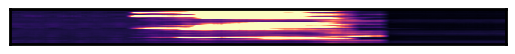

In [74]:
plt.figure()
smooth_sz_vals = sc.ndimage.uniform_filter1d(raw_sz_vals,20,axis=1)
plt.imshow(smooth_sz_vals)
plt.clim((0,5))
plt.xticks([])
plt.yticks([])

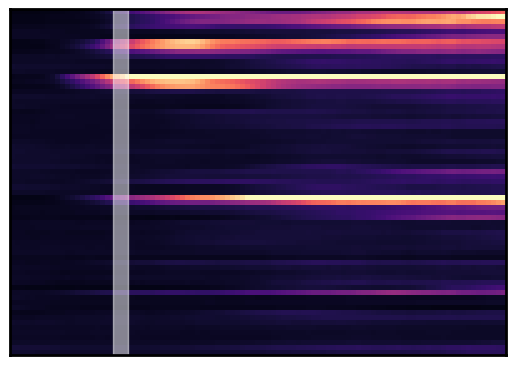

In [75]:
time_mask = (time_wins > 110) & (time_wins < 160)
plt.imshow(smooth_sz_vals[:,time_mask],cmap='magma')
plt.clim([0,10])
tiks = np.arange(0,smooth_sz_vals.shape[1],50)
# plt.xticks(tiks,times[tiks].astype(int))
span_start = np.argmin(np.abs(time_wins-10))
plt.axvspan(span_start,span_start+3,alpha=0.5,color='white')
plt.xticks([])
plt.yticks([])
plt.savefig(ospj(figpath,'example_seizure_just_onset_detection.pdf'))

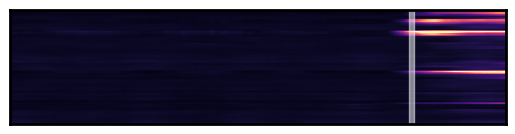

In [76]:
time_mask = (time_wins > 0) & (time_wins < 150)
plt.imshow(smooth_sz_vals[:,time_mask],cmap='magma')
plt.clim([0,10])
tiks = np.arange(0,smooth_sz_vals.shape[1],50)
# plt.xticks(tiks,times[tiks].astype(int))
span_start = np.argmin(np.abs(time_wins-120))
plt.axvspan(span_start,span_start+3,alpha=0.5,color='White')
plt.xticks([])
plt.yticks([])
plt.savefig(ospj(figpath,'example_seizure_onset_detection.pdf'))

In [77]:
# plt.figure()
# plt.imshow(np.median(seizure_mat,1).T)
# plt.figure()
# temp = np.exp(np.mean(seizure_mat,1).T)
# plt.imshow(temp/np.max(temp))
# plt.colorbar()
# plt.figure()
# temp = np.mean(np.exp(seizure_mat),1).T
# plt.imshow(temp/np.max(temp))
# plt.colorbar()
# plt.figure()
# temp = np.exp(np.percentile(seizure_mat,75,axis=1).T)
# plt.imshow(temp/np.max(temp))
# plt.colorbar()
# plt.figure()
# temp = np.percentile(np.exp(seizure_mat),75,axis=1).T
# plt.imshow(temp/np.max(temp))
# plt.colorbar()

## DSOSD Package

In [42]:
# model = NDD(fs=128,hidden_size=100,num_epochs=75,
# train_win = 256,pred_win=128,
# w_size=10,w_stride=1,
# use_cuda=True,
# batch_size=64)
model = NDD(fs=128)
model.fit(seizure_prep.loc[:fs*120/2,:])

# generate seizure likelihood feature (NDD)
sz_prob = model(seizure_prep)

In [43]:
sz_prob_times = model.get_win_times(len(seizure_prep))
time_mask = (sz_prob_times >= 60) & (sz_prob_times <= 180)
onset_idx = np.argmin(np.abs(sz_prob_times - 120)) - np.where(time_mask)[0][0]

In [49]:
threshold = model.get_gaussianx_threshold(sz_prob.iloc[:,:],noise_floor='medianover')
# threshold = model.get_cval_threshold()
threshold

4.211821040983162

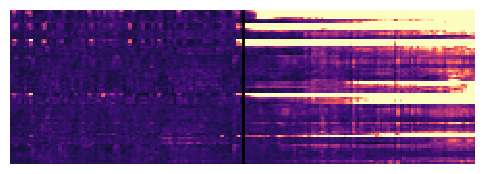

In [50]:
_,ax = plt.subplots(figsize=(6,2))

ax.matshow(sz_prob.loc[time_mask,:].T,aspect='auto',vmin=np.min(sz_prob.to_numpy().flatten()),vmax=threshold)
ax.axvline(onset_idx,c='black')
ax.set_yticks([])
ax.set_xticks([])
for spine in ax.spines.values():
            spine.set_visible(False)

In [51]:
sz_spread,sz_smooth = model.get_onset_and_spread(sz_prob.iloc[120:,:],ret_smooth_mat=True,rwin_size=15,rwin_req=14,filter_w=15)

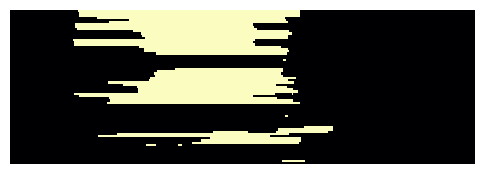

In [52]:
_,ax = plt.subplots(figsize=(6,2))
# ax.axvline(60,c='white')
# ax.matshow(sz_smooth.loc[time_mask[onset_idx:],:].T,aspect='auto')
ax.matshow(sz_smooth.T,aspect='auto')
ax.set_yticks([])
ax.set_xticks([])
for spine in ax.spines.values():
            spine.set_visible(False)

In [53]:
sz_spread

LC01-LC02  LC02-LC03  LI01-LI02  LC03-LC04  LB02-LB03  LB01-LB02  \
0        116        118        119        119        120        121   

   LB03-LB04  LA01-LA02  LA03-LA04  LI02-LI03  ...  LF01-LF02  LU04-LU05  \
0        125        126        127        128  ...        305        337   

   LU03-LU04  LU02-LU03  LQ05-LQ06  LQ04-LQ05  LY10-LY11  LE03-LE04  \
0        354        370        376        496        504        507   

   LO06-LO07  LQ03-LQ04  
0        509        545  

[1 rows x 48 columns]

In [54]:
plt.figure(figsize=(6,6))
early_spread = sz_spread.loc[:,sz_spread.loc[0,:].to_numpy() < 60]
idxs = early_spread.to_numpy().reshape(-1,)
idxs -= min(idxs)
sz_ch_arr = early_spread.columns
# plt.bar(np.arange(len(idxs)),sz_times_arr[idxs],color='green')
plot_times_arr = max(sz_prob_times) - sz_prob_times
sns.barplot(x=np.arange(len(idxs)),y=plot_times_arr[idxs],palette='magma_r',orient='v')
sns.despine()
plt.xticks(np.arange(len(idxs)),sz_ch_arr,rotation=60,ha='right')
t = plt.yticks()
y_tix = max(sz_prob_times) - np.arange(0,221,10)
plt.yticks(y_tix,np.arange(0,221,10),fontsize=20)
# plt.axhline(max(sz_prob_times)-3,ls='--',color='red',linewidth=2)
# plt.axhline(max(sz_times_arr)-10,ls='--',color='blue',linewidth=2)
plt.ylabel("Time (s)",fontsize=24)
# plt.title('Seizure spread after onset',fontsize=28)
plt.ylim([max(sz_prob_times)-sz_prob_times[idxs[-1]],max(sz_prob_times)])


ValueError: min() arg is an empty sequence

<Figure size 600x600 with 0 Axes>

In [ ]:
sz_spread = model.get_onset_and_spread(sz_prob)

## Plotting data variance

In [55]:
_,_,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/sauce/littlab/users/wojemann/stim-seizures/code','config.json'))
consensus_annots = pd.read_pickle(ospj(prodatapath,"threshold_tuning_consensus.pkl"))
consensus_annots['Patient'] = consensus_annots['patient']
consensus_annots.sort_values('approximate_onset',inplace=True)

In [56]:
viz_data = pd.read_pickle(ospj(prodatapath,'onset_visualization_data.pkl'))
viz_data['State'] = viz_data['type'].map({'ueo':'Onset','inter':'Baseline','sec':'Spread'})
viz_data['patient'] = viz_data['Patient']
viz_data.loc[~viz_data.patient.isin(['HUP238','HUP253']),'patient'] = 'test'

In [57]:
def psd_fun(signal):
    return abs(sc.fft.fft(signal)[:128])
all_psds = []
for i,row in viz_data.iterrows():
    smooth_psd = sc.ndimage.uniform_filter1d(psd_fun(row.signal),5)
    all_psds.append(smooth_psd)
all_psd_array = np.vstack(all_psds)

In [58]:
len(viz_data)

997

### 2D Scatter and clustering

In [59]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, SpectralEmbedding

In [60]:
mfld = TSNE(random_state=0)
embeddings = mfld.fit_transform(all_psd_array)
# mfld = SpectralEmbedding(random_state=0)
# embeddings = mfld.fit_transform(all_psd_array)

In [61]:
# _,ax = plt.subplots(figsize=(6,7))
# sns.scatterplot(x=embeddings[:,1],y=embeddings[:,0],
# # hue=viz_data[viz_data.patient == 'test']['patient'],
# hue=viz_data.type=='inter',
# style=viz_data['State'],
# markers=['o','^','s'],
# # palette='rocket',
# # palette=sns.color_palette("ch:s=-.2,r=.6"),
# palette='Blues',
# legend=False,
# alpha=0.7,
# ax=ax)

# # sns.scatterplot(x=embeddings[viz_data.patient == 'HUP253',0],y=embeddings[viz_data.patient == 'HUP253',1],
# # hue=viz_data[viz_data.patient == 'HUP253']['State'],
# # style=viz_data[viz_data.patient == 'HUP253']['State'],
# # hue_order=['Normal','Onset','Spread'],
# # markers=['o','^','s'],
# # palette='spring_r',
# # legend=False,
# # ax=ax,
# # s=60)

# pt2='HUP250'
# sns.scatterplot(x=embeddings[viz_data.Patient == pt2,1],y=embeddings[viz_data.Patient == pt2,0],
# markers=['o','^','s'],
# hue=viz_data[viz_data.Patient == pt2]['State'],
# style=viz_data[viz_data.Patient == pt2]['State'],
# hue_order=['Baseline','Onset','Spread'],
# palette='rocket',
# legend=True,
# ax=ax,
# s=60)

# sns.despine()
# plt.xlabel('t-SNE 1')
# plt.ylabel('t-SNE 2')
# plt.xticks([])
# plt.yticks([])
# plt.title('Embeddings of Neural Spectra')

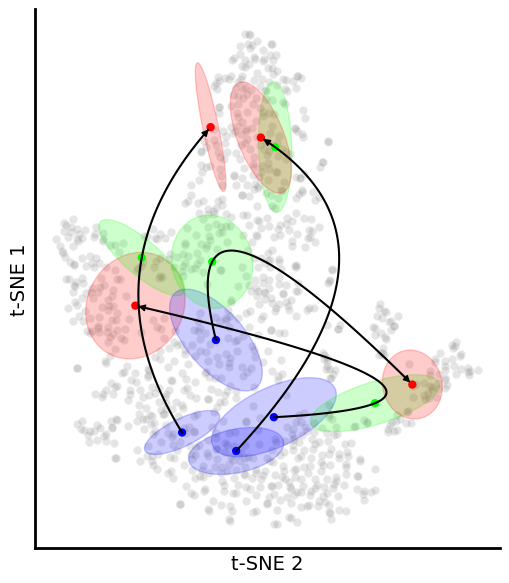

In [62]:
x=embeddings[:,1]
y=embeddings[:,0]
xy = np.hstack((x.reshape(-1,1),y.reshape(-1,1)))

# Compute centroids of each state across all patients
centroid_points = np.array([xy[viz_data["State"] == state].mean(axis=0) for state in ['Baseline','Onset','Spread']])

def plot_confidence_ellipse(cov, mean, ax, color, alpha=0.2):
    """Draw an ellipse representing the covariance matrix at the mean position."""
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 1]))  # Rotation angle
    width, height = 2 * np.sqrt(eigenvalues)  # Convert variances to width/height

    ellipse = patches.Ellipse(mean, width, height, angle, color=color, alpha=alpha, edgecolor=color)
    ax.add_patch(ellipse)

# Initialize plot
_,ax = plt.subplots(figsize=(6,7))

sns.scatterplot(x=x,y=y,
color='gray',
legend=False,
alpha=0.2,
ax = ax)

state_base_colors = {"Baseline": (0, 0, 1),  # Blue
                     "Onset": (0, 1, 0),    # Green
                     "Spread": (1, 0, 0)}   # Red


for i_pt,patient in enumerate(viz_data["Patient"].unique()):
    if patient in ['HUP225','HUP253','HUP246','HUP257']:
        a = 1
    else:
        continue

    mask = viz_data["Patient"] == patient
    patient_embeddings = np.hstack([x[mask].reshape(-1,1),y[mask].reshape(-1,1)])
    patient_states = viz_data["State"][mask]
    
    centroids = dict()
    for state in ['Baseline','Onset','Spread']:
        state_mask = patient_states == state
        mean = patient_embeddings[state_mask].mean(axis=0)
        centroids[state] = mean
        cov = np.cov(patient_embeddings[state_mask].T)  # Compute covariance
        plot_confidence_ellipse(cov, mean, ax, state_base_colors[state])


    for label,coord in centroids.items():
        ax.scatter(coord[0],coord[1],edgecolor='none',alpha=a,label=label,color=state_base_colors[label])
    
    # Sort centroids in order: baseline → onset → spread
    sorted_states = ['Baseline','Onset','Spread']
    sorted_centroids = np.array([centroids[state] for state in sorted_states if state in centroids])

    # ax.text(
    # sorted_centroids[-1, 0] + 1, sorted_centroids[-1, 1] + 1,  # Offset label slightly
    # patient, 
    # fontsize=10, color="black", fontweight="bold"
    # )

    # Fit a smoothed spline curve through centroids
    if len(sorted_centroids) > 1:
        spline_order = min(len(sorted_centroids) - 1, 3)
        tck, u = sc.interpolate.splprep([sorted_centroids[:, 0], sorted_centroids[:, 1]], k=spline_order,s=0.5)
        smooth_x, smooth_y = sc.interpolate.splev(np.linspace(0, 1, 100), tck)
        ax.plot(smooth_x[:-1], smooth_y[:-1], "black", linewidth=1.5,alpha=a)       
        ax.annotate(
        "", xy=(smooth_x[-1], smooth_y[-1]), xytext=(smooth_x[-3], smooth_y[-3]),
        arrowprops=dict(arrowstyle="-|>", color="black", lw=1,alpha=a)
    )

# Labels and legend
ax.set_xlabel("t-SNE 2")
ax.set_ylabel("t-SNE 1")
ax.set_xticks([])
ax.set_yticks([])
sns.despine()
plt.savefig(ospj(figpath,'patient_path_embedding.pdf'),bbox_inches='tight')

### Traces

Onset 45666.63 RB01


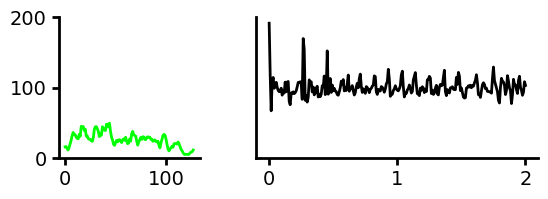

Onset 45666.63 RB02


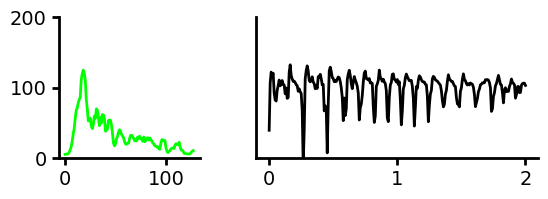

Onset 45666.63 RB03


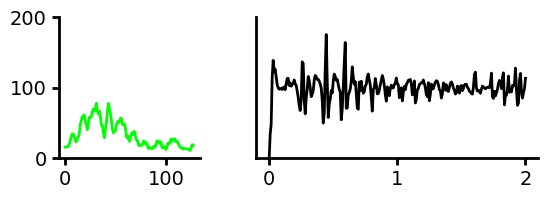

Onset 45666.63 RC01


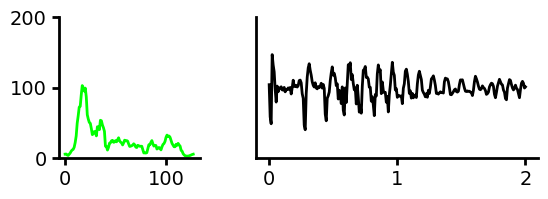

Onset 45666.63 RC02


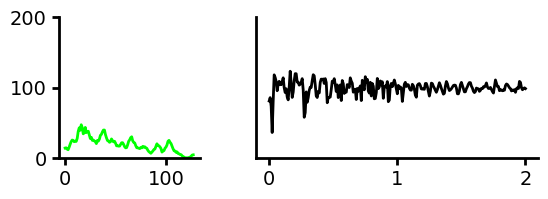

Spread 45666.63 RA01


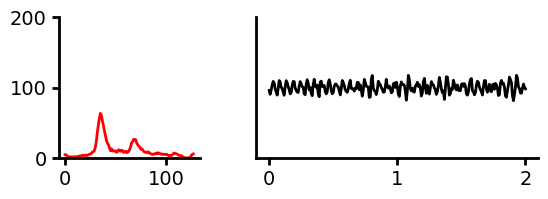

Spread 45666.63 RA02


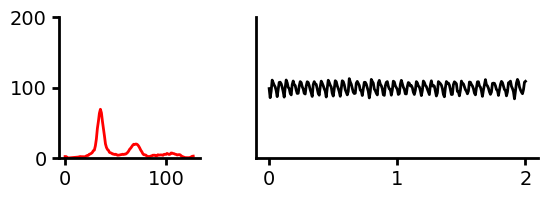

Spread 45666.63 RA03


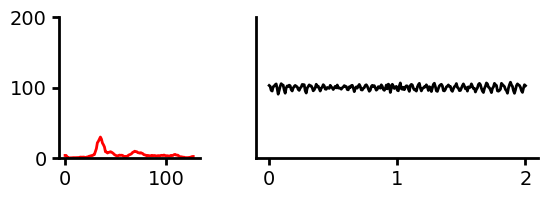

Spread 45666.63 RA04


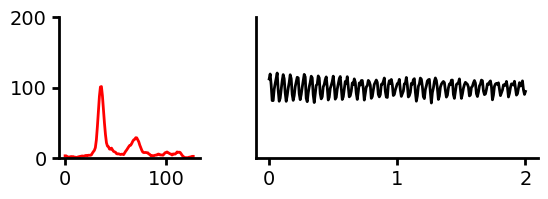

Spread 45666.63 RA05


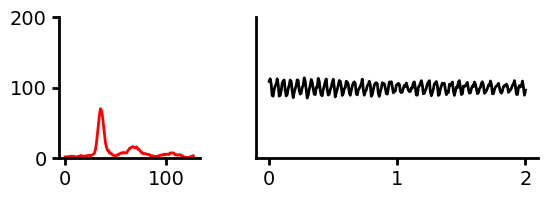

Spread 45666.63 RB01


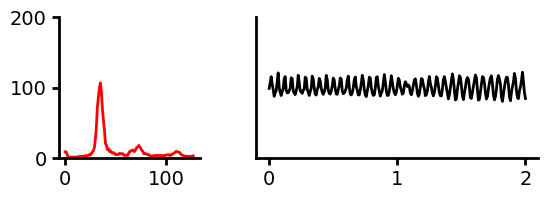

Spread 45666.63 RB02


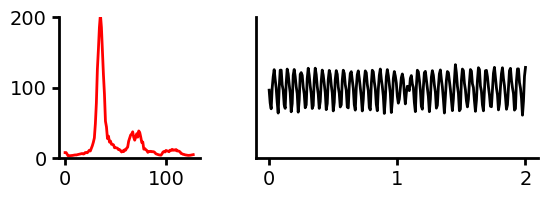

Spread 45666.63 RB03


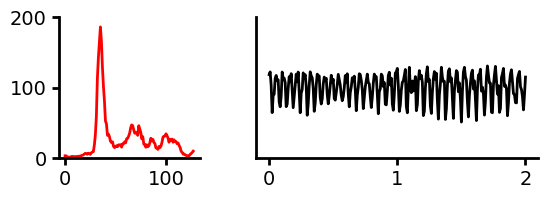

Spread 45666.63 RB04


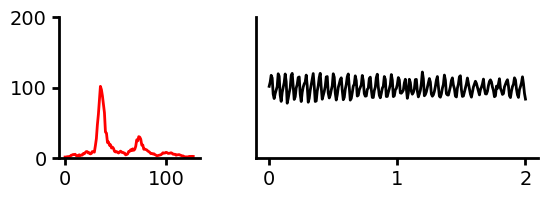

Spread 45666.63 RC01


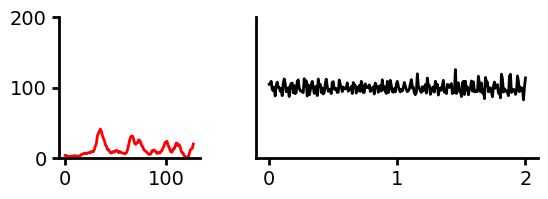

Spread 45666.63 RC02


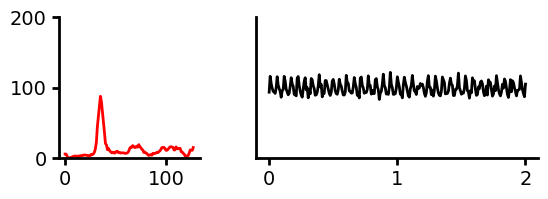

Spread 45666.63 RC03


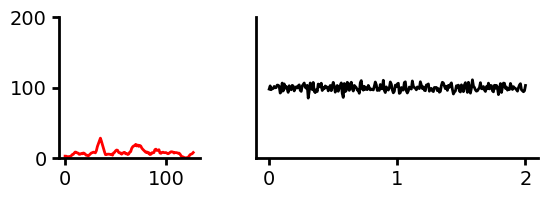

Spread 45666.63 RD01


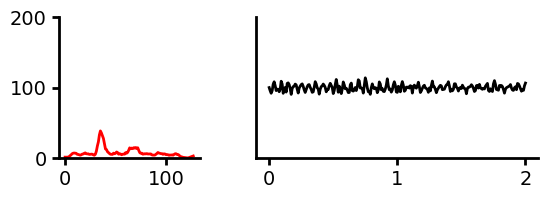

Spread 45666.63 RD02


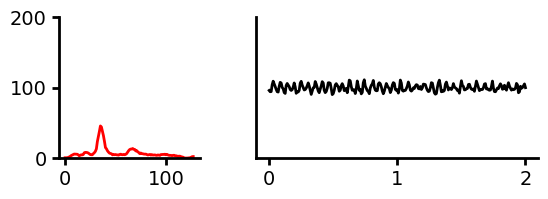

Spread 45666.63 RX01


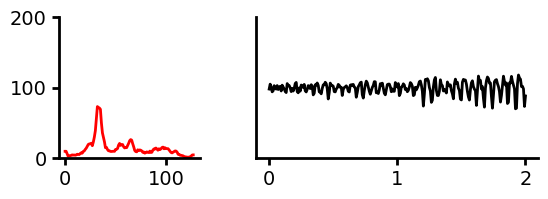

Spread 45666.63 RX02


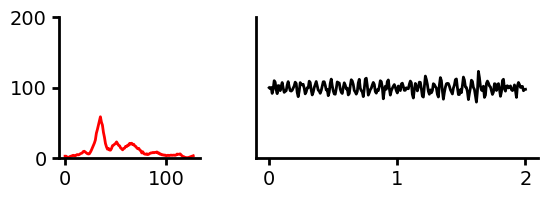

Baseline 45666.63 RX02


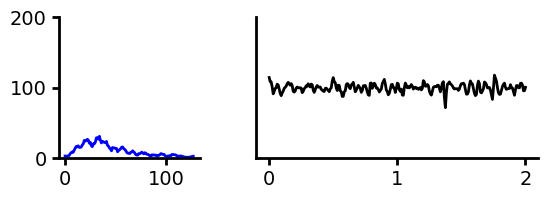

Baseline 45666.63 RB04


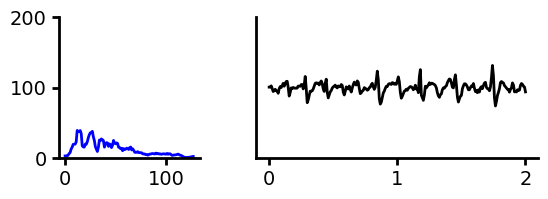

Baseline 45666.63 RB03


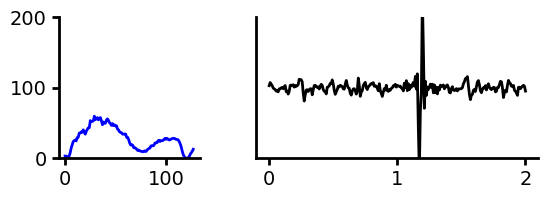

Baseline 45666.63 RC03


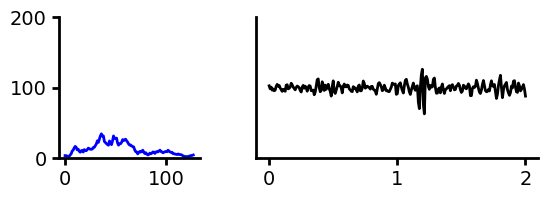

Baseline 45666.63 RA02


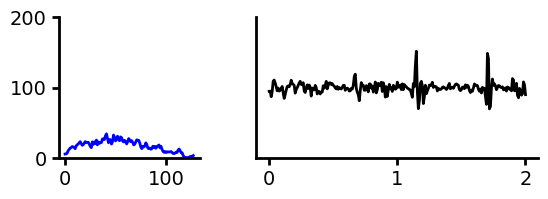

Baseline 45666.63 RA01


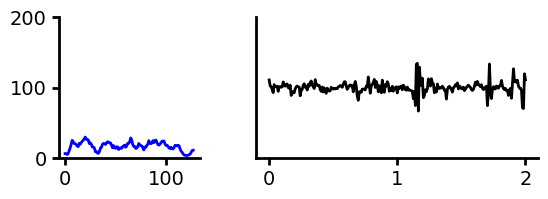

Baseline 45666.63 RB02


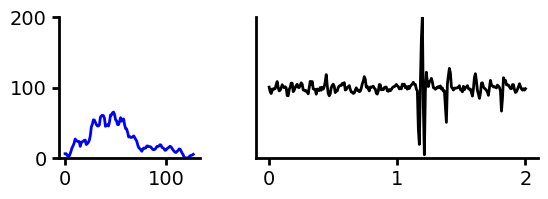

Baseline 45666.63 RA03


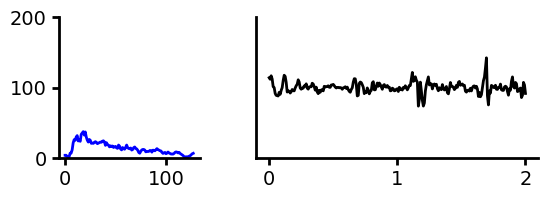

Baseline 45666.63 RC01


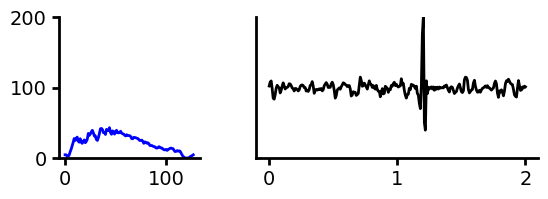

Baseline 45666.63 RA04


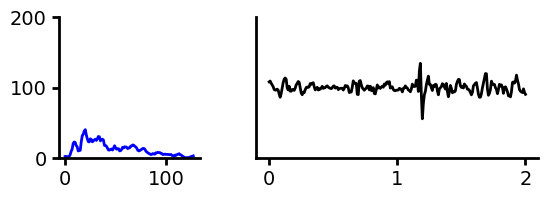

Baseline 45666.63 RA05


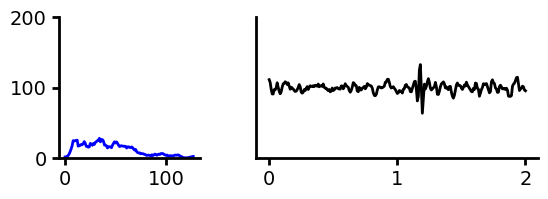

Baseline 45666.63 RX01


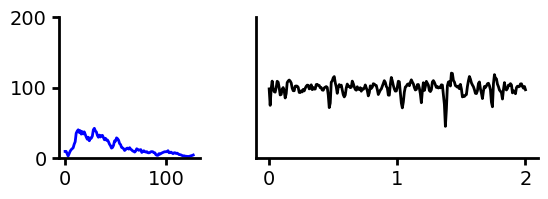

Baseline 45666.63 RD01


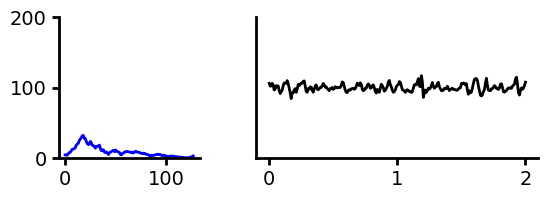

Baseline 45666.63 RD02


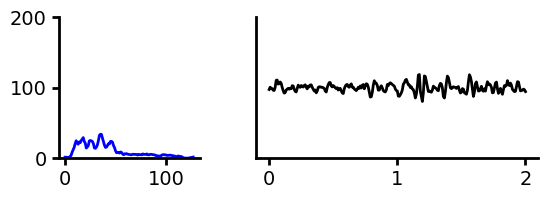

Baseline 45666.63 RB01


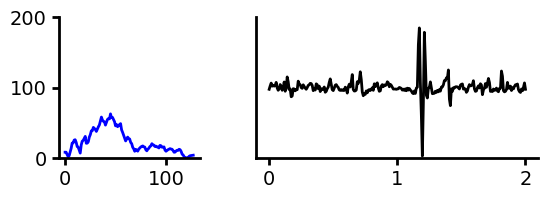

Baseline 45666.63 RC02


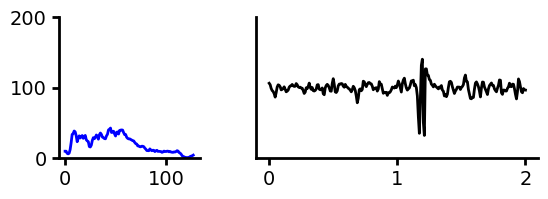

Onset 68657.34 RB01


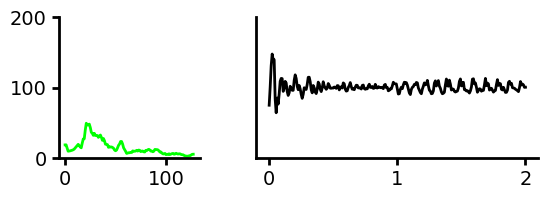

Onset 68657.34 RB02


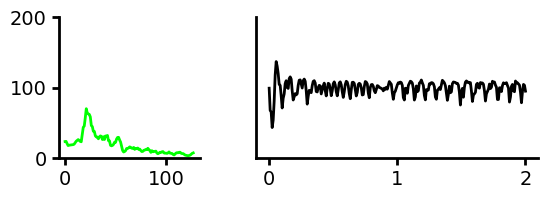

Onset 68657.34 RC01


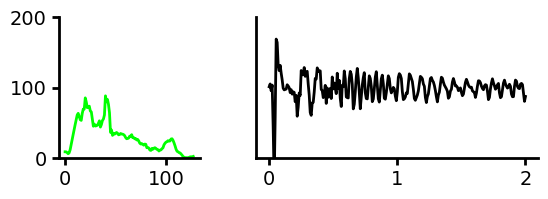

Onset 68657.34 RC02


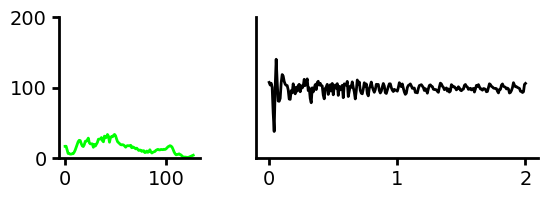

Spread 68657.34 RA03


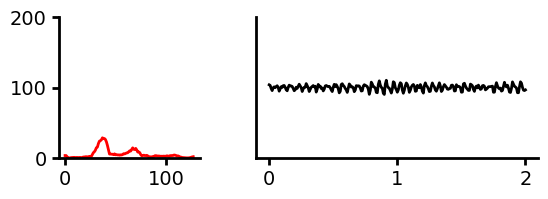

Spread 68657.34 RA04


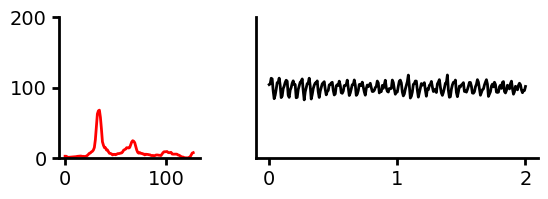

Spread 68657.34 RA05


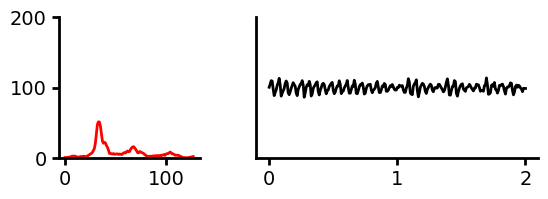

Spread 68657.34 RB01


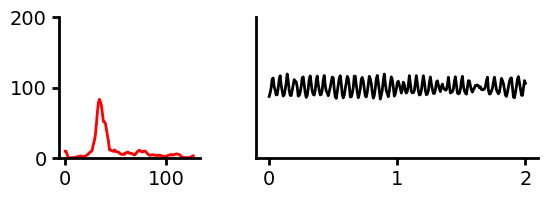

Spread 68657.34 RB02


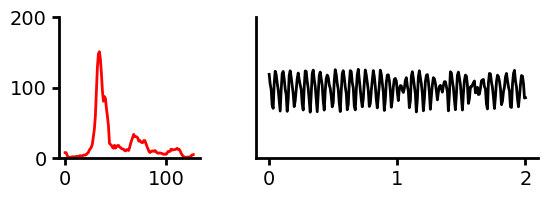

Spread 68657.34 RB03


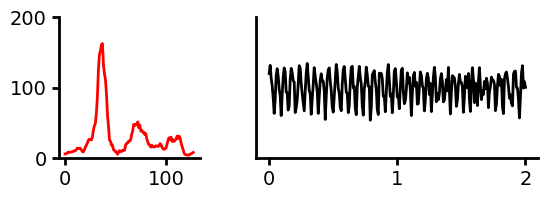

Spread 68657.34 RC01


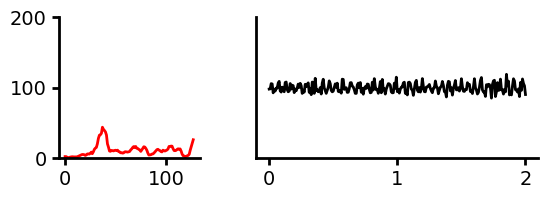

Spread 68657.34 RC02


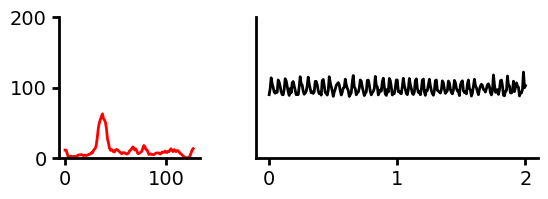

Spread 68657.34 RD01


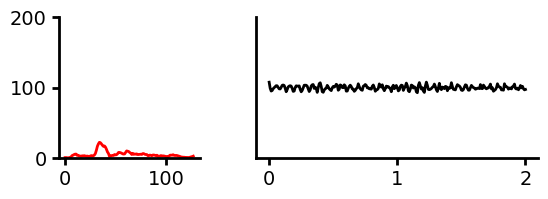

Spread 68657.34 RD02


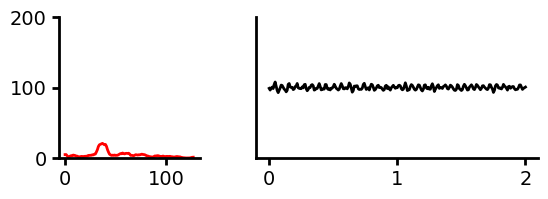

Spread 68657.34 RD03


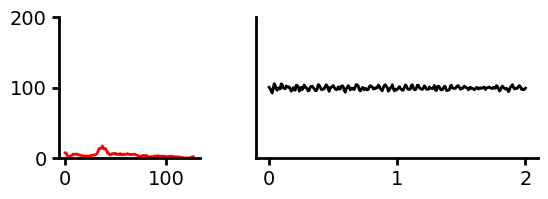

Spread 68657.34 RX01


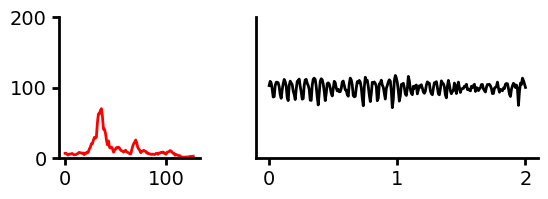

Baseline 68657.34 RB03


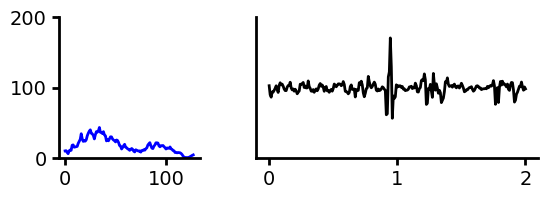

Baseline 68657.34 RA03


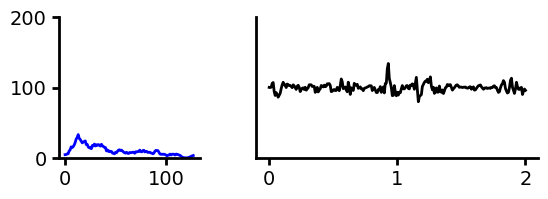

Baseline 68657.34 RB02


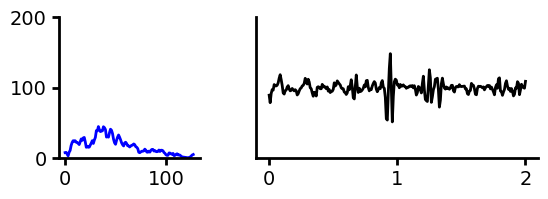

Baseline 68657.34 RC01


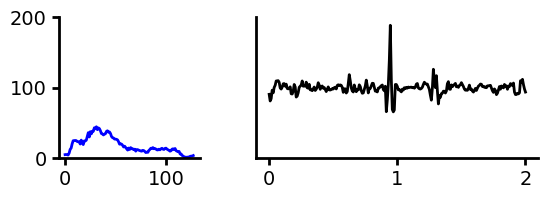

Baseline 68657.34 RA04


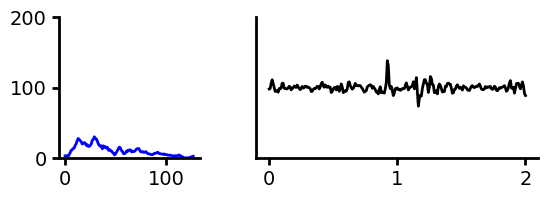

Baseline 68657.34 RA05


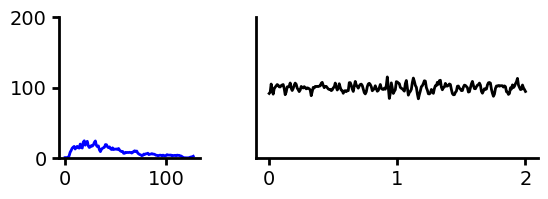

Baseline 68657.34 RX01


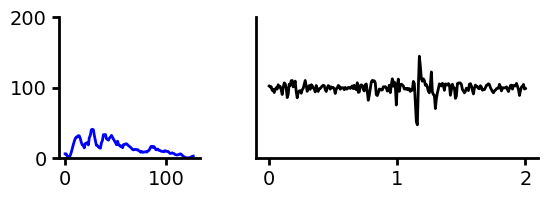

Baseline 68657.34 RD01


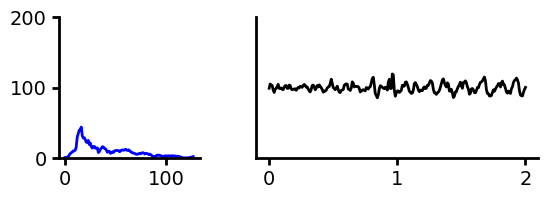

Baseline 68657.34 RD02


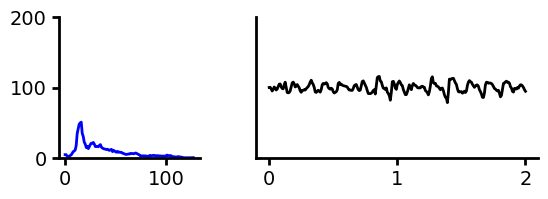

Baseline 68657.34 RB01


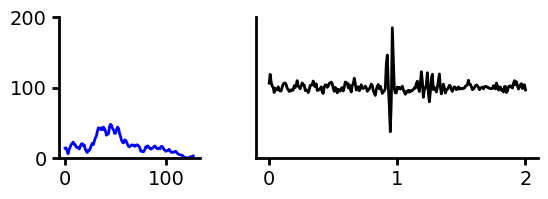

Baseline 68657.34 RC02


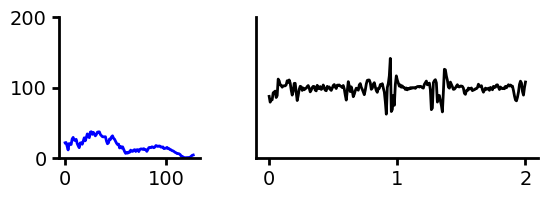

Baseline 68657.34 RD03


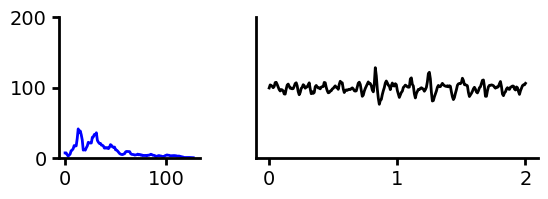

Onset 286026.36 RB01


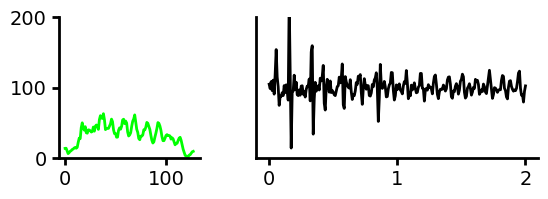

Onset 286026.36 RB02


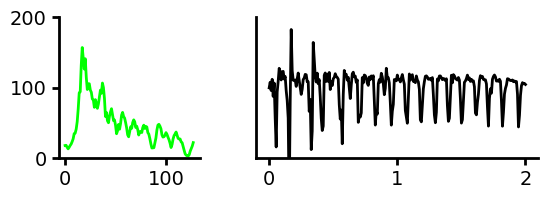

Onset 286026.36 RB03


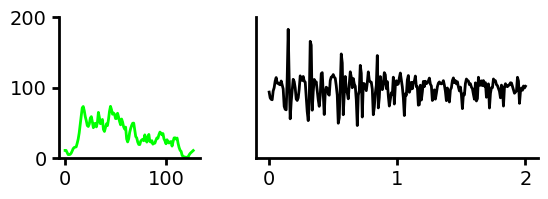

Onset 286026.36 RC01


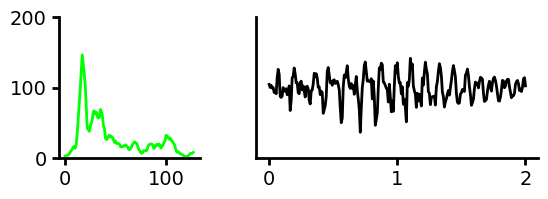

Onset 286026.36 RC02


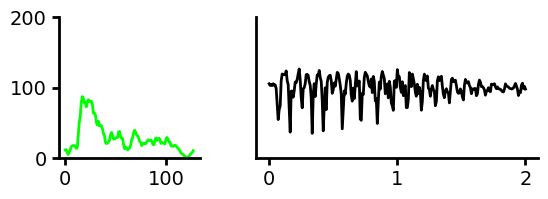

Spread 286026.36 RA01


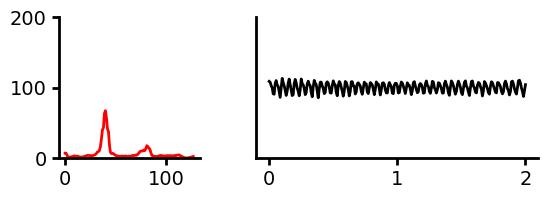

Spread 286026.36 RA02


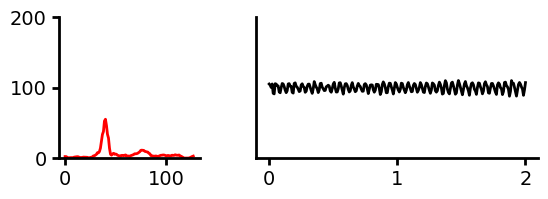

Spread 286026.36 RA03


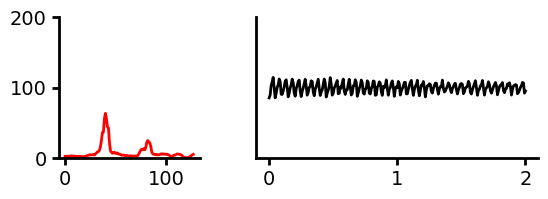

Spread 286026.36 RA04


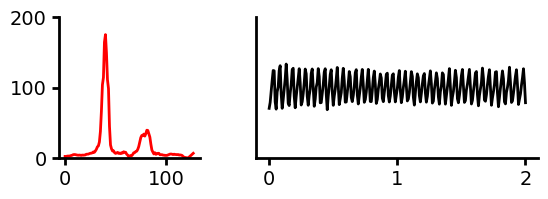

Spread 286026.36 RA05


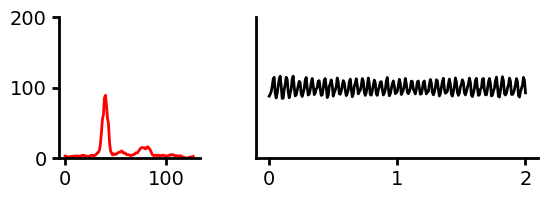

Spread 286026.36 RB01


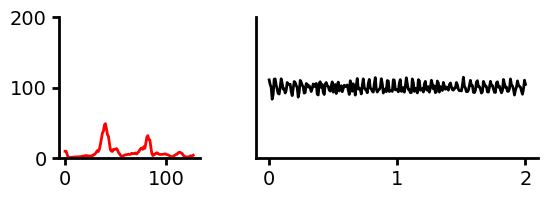

Spread 286026.36 RB02


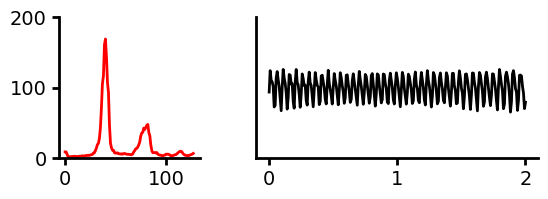

Spread 286026.36 RB03


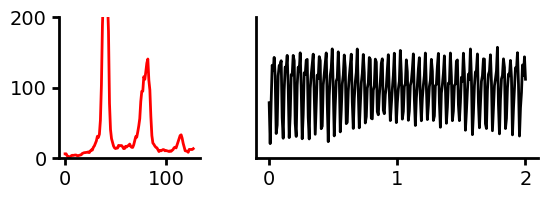

Spread 286026.36 RB04


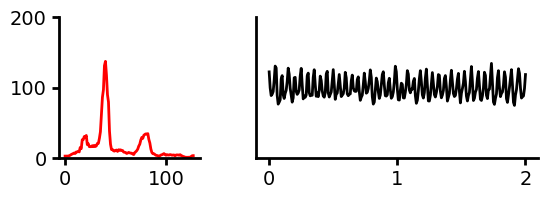

Spread 286026.36 RC01


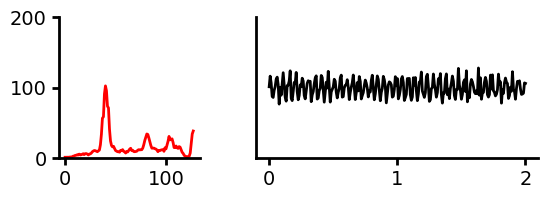

Spread 286026.36 RC02


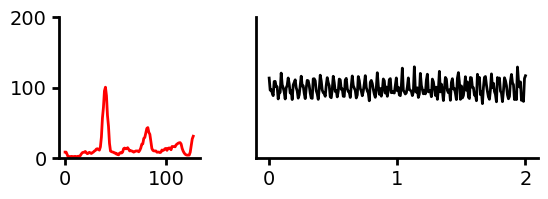

Spread 286026.36 RD01


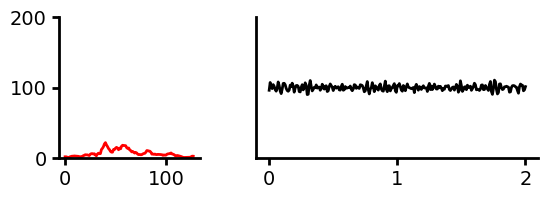

Spread 286026.36 RD02


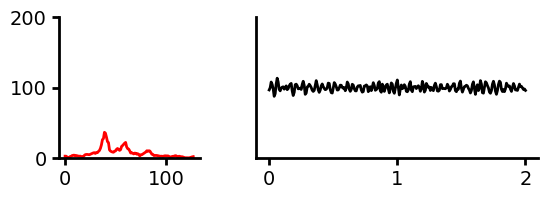

Spread 286026.36 RD03


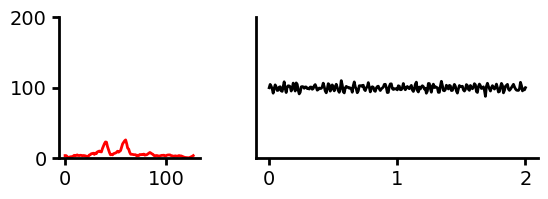

Spread 286026.36 RX01


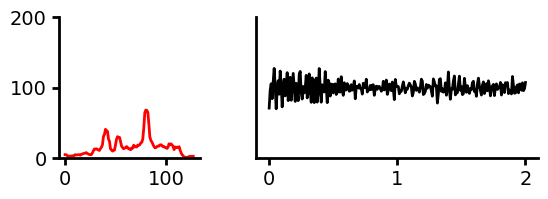

Baseline 286026.36 RB04


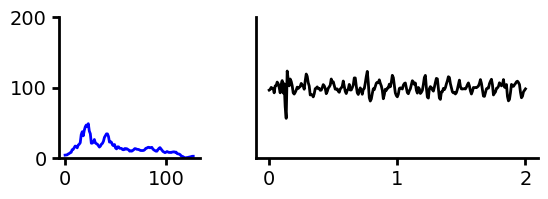

Baseline 286026.36 RB03


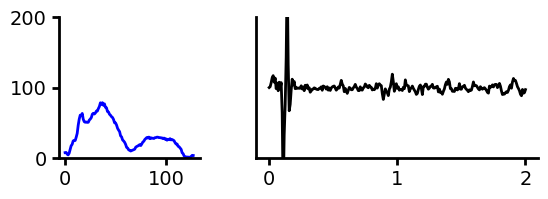

Baseline 286026.36 RA02


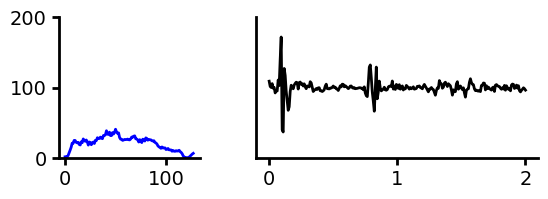

Baseline 286026.36 RA01


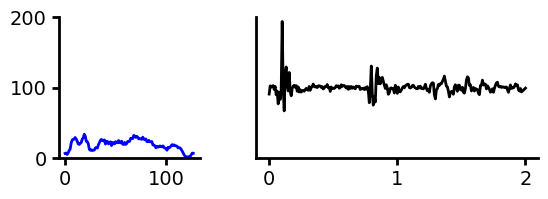

Baseline 286026.36 RB02


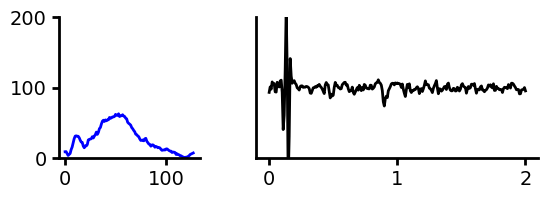

Baseline 286026.36 RA03


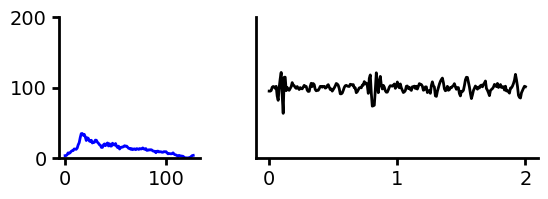

Baseline 286026.36 RC01


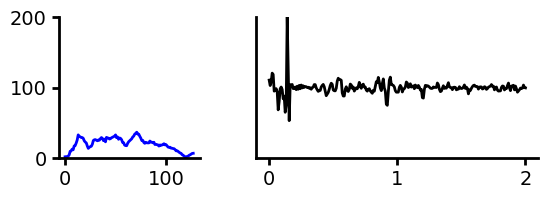

Baseline 286026.36 RA04


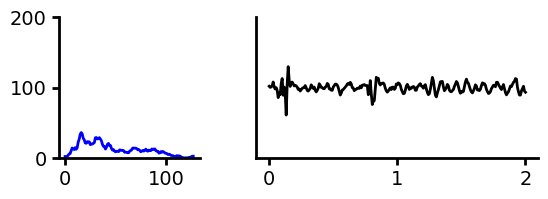

Baseline 286026.36 RA05


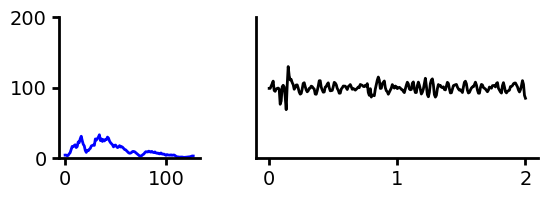

Baseline 286026.36 RX01


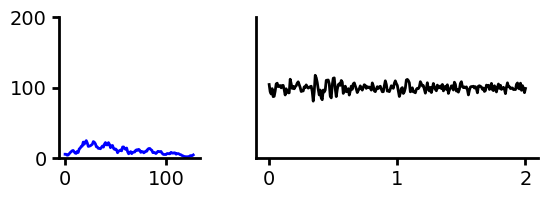

Baseline 286026.36 RD01


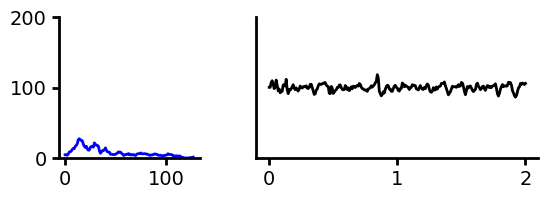

Baseline 286026.36 RD02


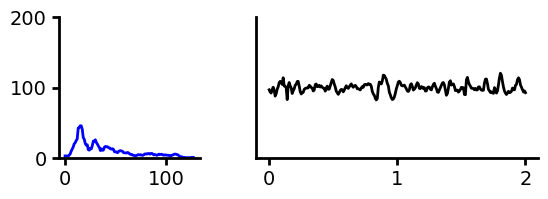

Baseline 286026.36 RB01


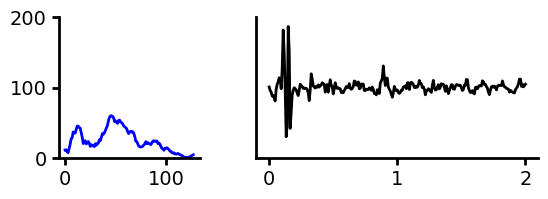

Baseline 286026.36 RC02


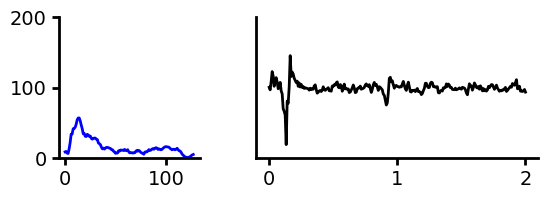

Baseline 286026.36 RD03


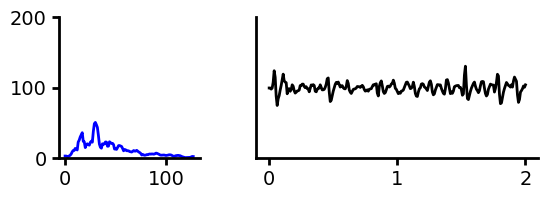

In [63]:
c_dict = {state: sns.color_palette('rocket',n_colors=3)[i] for i,state in enumerate(['Baseline','Onset','Spread'])}

for i,row in viz_data[viz_data.Patient == 'HUP253'].iterrows():
    print(row.State, row.approximate_onset, row.channel)
    # Create a figure
    fig = plt.figure(figsize=(6, 2),)

    # Define a GridSpec with 1 row and 4 columns
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)

    # Create the square plot in the first column
    ax1 = fig.add_subplot(spec[0])
    ax1.plot(all_psd_array[i,:],c=state_base_colors[row.State])
    # ax1.set_title(row.State)
    ax1.set_ylim([0,200])
    ax1.set_box_aspect(1)  # Use set_box_aspect instead of set_aspect    # for spine in ax.spines.values():
    #         spine.set_visible(False)
    sns.despine(ax=ax1)
    # Create the rectangular plot spanning the remaining columns
    ax2 = fig.add_subplot(spec[1:])
    ax2.plot(row.signal,c='black')
    ax2.set_yticks([])
    ax2.set_xticks([0,128,256],[0,1,2])
    ax2.set_ylim([-15,15])
    # ax2.set_aspect('auto')  # For the rectangular plot
    ax2.set_box_aspect(1/2)
    sns.despine(ax=ax2)
    # fig.suptitle(row.State)
    plt.tight_layout()
    plt.show()
    # # Adjust layout and display
    # plt.tight_layout()
    # plt.show()

    # fig,axs = plt.subplots(1,2,figsize=(10,3))
    # axs[0].plot(row.signal)
    # axs[0].set_title(row.State)
    # axs[0].set_ylim([-10,10])
    # axs[1].plot(sc.ndimage.uniform_filter1d(all_psd_array[i,:],10))
    # axs[1].set_xscale('log')
    # axs[1].set_ylim([0,100])
    # plt.show()

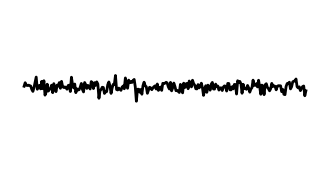

In [ ]:
_,ax = plt.subplots(figsize=(4,2))
plt.plot(viz_data[(viz_data.Patient=='HUP235') & (viz_data.State=='Baseline')].signal.iloc[8],c='black')
plt.ylim([-15,15])
for i,spine in enumerate(ax.spines.values()):
    spine.set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig(ospj(figpath,'example_eeg_trace.pdf'),bbox_inches='tight',transparent=True)

### 3D Scatter

In [ ]:
mfld = SpectralEmbedding(random_state=0,n_components=3)
embeddings = mfld.fit_transform(all_psd_array)

In [ ]:
embeddings.shape

(997, 3)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# fig = go.Figure(data=[go.Scatter3d(
#                                 x=embeddings[:,0],
#                                 y=embeddings[:,1],
#                                 z=embeddings[:,2],
#                                 mode='markers',
#                                 marker=dict(
#                                     symbol=['square' if i == 'Normal' else 'cross' for i in viz_data.State],
#                                     size=4,
#                                     color=viz_data.State.map({'Transition':1,'Seizure':2,'Normal':0}),
#                                     colorscale='Blues',
#                                     opacity=.1,
#                                     line={'width':0}
#                                 )
#                                 )])

# fig.update_layout(template='plotly_white',scene = dict(
#     xaxis = dict(showgrid = False,showticklabels = False),
#                                    yaxis = dict(showgrid = False,showticklabels = False),
#                                    zaxis = dict(showgrid = False,showticklabels = False)
#              ))